In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

ticker = "AAPL"
tkr = yf.Ticker(ticker)

income = tkr.financials
bs = tkr.balance_sheet
cf = tkr.cashflow

print("✅ Loaded yfinance statements for:", ticker)
print("Income shape:", income.shape)
print("Balance sheet shape:", bs.shape)
print("Cashflow shape:", cf.shape)


/usr/local/python/3.12.1/lib/python3.12/site-packages/yfinance/scrapers/fundamentals.py:120: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end = pd.Timestamp.utcnow().ceil("D")
/usr/local/python/3.12.1/lib/python3.12/site-packages/yfinance/scrapers/fundamentals.py:120: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end = pd.Timestamp.utcnow().ceil("D")
/usr/local/python/3.12.1/lib/python3.12/site-packages/yfinance/scrapers/fundamentals.py:120: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end = pd.Timestamp.utcnow().ceil("D")


✅ Loaded yfinance statements for: AAPL
Income shape: (39, 5)
Balance sheet shape: (69, 5)
Cashflow shape: (53, 5)


In [ ]:
print("=== INCOME STATEMENT rows (first 30) ===")
print(income.index.tolist()[:30])

print("\n=== BALANCE SHEET rows (first 30) ===")
print(bs.index.tolist()[:30])

print("\n=== CASHFLOW rows (first 30) ===")
print(cf.index.tolist()[:30])


=== INCOME STATEMENT rows (first 30) ===
['Tax Effect Of Unusual Items', 'Tax Rate For Calcs', 'Normalized EBITDA', 'Net Income From Continuing Operation Net Minority Interest', 'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA', 'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income', 'Normalized Income', 'Net Income From Continuing And Discontinued Operation', 'Total Expenses', 'Total Operating Income As Reported', 'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS', 'Basic EPS', 'Diluted NI Availto Com Stockholders', 'Net Income Common Stockholders', 'Net Income', 'Net Income Including Noncontrolling Interests', 'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income', 'Other Income Expense', 'Other Non Operating Income Expenses', 'Net Non Operating Interest Income Expense', 'Interest Expense Non Operating']

=== BALANCE SHEET rows (first 30) ===
['Treasury Shares Number', 'Ordinary Shares Number', 'Share Issued', 'Net Debt', 'Tota

In [ ]:
# The minimal dataset 

def pick(df, row_name, col_name):
    s = df.loc[row_name]
    s.index = pd.to_datetime(s.index).year
    s = pd.to_numeric(s, errors="coerce").sort_index()
    s.name = col_name
    return s

data = pd.concat([
    # Income statement
    pick(income, "Total Revenue", "revenue") if "Total Revenue" in income.index else pick(income, "Total Expenses", "revenue"),  # fallback (rare)
    pick(income, "Net Income", "net_income"),
    pick(income, "EBIT", "ebit"),
    pick(income, "Diluted Average Shares", "diluted_shares"),

    # Balance sheet
    pick(bs, "Total Assets", "assets") if "Total Assets" in bs.index else pick(bs, "Invested Capital", "assets"),                # fallback (rare)
    pick(bs, "Stockholders Equity", "equity"),
    pick(bs, "Total Debt", "total_debt"),

    # Cashflow
    pick(cf, "Free Cash Flow", "fcf"),
    pick(cf, "Repurchase Of Capital Stock", "buybacks"),
    pick(cf, "Capital Expenditure", "capex"),
    pick(cf, "Cash Dividends Paid", "dividends_paid")
], axis=1)

# Simple derived metrics (for visuals + interpretation)
data["net_margin"] = data["net_income"] / data["revenue"]
data["roe"] = data["net_income"] / data["equity"]
data["leverage"] = data["assets"] / data["equity"]
data["eps"] = data["net_income"] / data["diluted_shares"]
data["buybacks_to_fcf"] = data["buybacks"] / data["fcf"]

data


,revenue,net_income,ebit,diluted_shares,assets,equity,total_debt,fcf,buybacks,capex,dividends_paid,net_margin,roe,leverage,eps,buybacks_to_fcf
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,3.943280e+11,9.980300e+10,1.194370e+11,1.632582e+10,3.527550e+11,5.067200e+10,1.324800e+11,1.114430e+11,-8.940200e+10,-1.070800e+10,-1.484100e+10,0.253096,1.969589,6.961537,6.113200,-0.802222
2023,3.832850e+11,9.699500e+10,1.143010e+11,1.581255e+10,3.525830e+11,6.214600e+10,1.110880e+11,9.958400e+10,-7.755000e+10,-1.095900e+10,-1.502500e+10,0.253062,1.560760,5.673462,6.134053,-0.778740
2024,3.910350e+11,9.373600e+10,1.232160e+11,1.540810e+10,3.649800e+11,5.695000e+10,1.066290e+11,1.088070e+11,-9.494900e+10,-9.447000e+09,-1.523400e+10,0.239713,1.645935,6.408780,6.083555,-0.872637
2025,4.161610e+11,1.120100e+11,1.330500e+11,1.500470e+10,3.592410e+11,7.373300e+10,9.865700e+10,9.876700e+10,-9.071100e+10,-1.271500e+10,-1.542100e+10,0.269151,1.519130,4.872187,7.464996,-0.918434


In [ ]:
#remove the all-NaN year

# Drop rows where revenue is missing 
data = data.dropna(subset=["net_income", "assets", "equity", "fcf"])

print("Years kept:", data.index.tolist())
print("\nMissing values per column:\n", data.isna().sum())

data


Years kept: [2022, 2023, 2024, 2025]

Missing values per column:
 revenue            0
net_income         0
ebit               0
diluted_shares     0
assets             0
equity             0
total_debt         0
fcf                0
buybacks           0
capex              0
dividends_paid     0
net_margin         0
roe                0
leverage           0
eps                0
buybacks_to_fcf    0
dtype: int64


,revenue,net_income,ebit,diluted_shares,assets,equity,total_debt,fcf,buybacks,capex,dividends_paid,net_margin,roe,leverage,eps,buybacks_to_fcf
2022,3.943280e+11,9.980300e+10,1.194370e+11,1.632582e+10,3.527550e+11,5.067200e+10,1.324800e+11,1.114430e+11,-8.940200e+10,-1.070800e+10,-1.484100e+10,0.253096,1.969589,6.961537,6.113200,-0.802222
2023,3.832850e+11,9.699500e+10,1.143010e+11,1.581255e+10,3.525830e+11,6.214600e+10,1.110880e+11,9.958400e+10,-7.755000e+10,-1.095900e+10,-1.502500e+10,0.253062,1.560760,5.673462,6.134053,-0.778740
2024,3.910350e+11,9.373600e+10,1.232160e+11,1.540810e+10,3.649800e+11,5.695000e+10,1.066290e+11,1.088070e+11,-9.494900e+10,-9.447000e+09,-1.523400e+10,0.239713,1.645935,6.408780,6.083555,-0.872637
2025,4.161610e+11,1.120100e+11,1.330500e+11,1.500470e+10,3.592410e+11,7.373300e+10,9.865700e+10,9.876700e+10,-9.071100e+10,-1.271500e+10,-1.542100e+10,0.269151,1.519130,4.872187,7.464996,-0.918434


In [6]:
(data[["assets","equity","total_debt","net_income","revenue","fcf"]]/1e9).round(1)


,assets,equity,total_debt,net_income,revenue,fcf
2022,352.8,50.7,132.5,99.8,394.3,111.4
2023,352.6,62.1,111.1,97.0,383.3,99.6
2024,365.0,57.0,106.6,93.7,391.0,108.8
2025,359.2,73.7,98.7,112.0,416.2,98.8


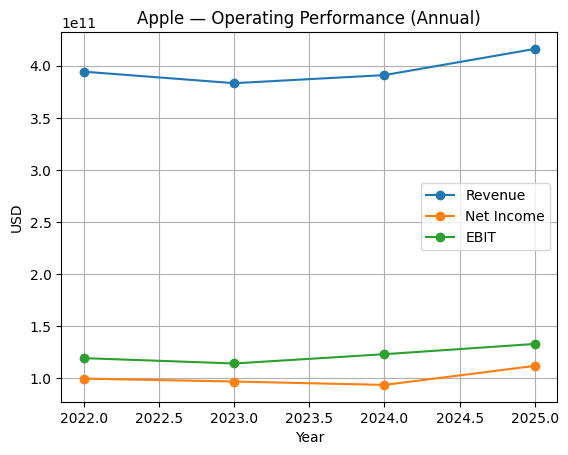

In [ ]:
#Operating performance (Revenue, Net Income, EBIT)

plt.figure()
plt.plot(data.index, data["revenue"], marker="o", label="Revenue")
plt.plot(data.index, data["net_income"], marker="o", label="Net Income")
plt.plot(data.index, data["ebit"], marker="o", label="EBIT")
plt.title("Apple — Operating Performance (Annual)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()


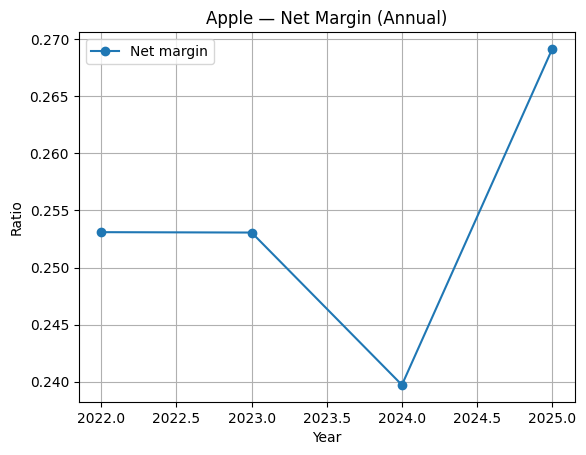

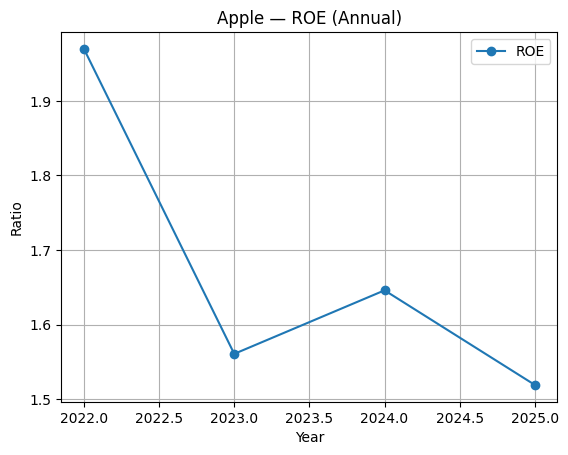

In [ ]:
#Margins (operational) + ROE (value creation)

plt.figure()
plt.plot(data.index, data["net_margin"], marker="o", label="Net margin")
plt.title("Apple — Net Margin (Annual)")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(data.index, data["roe"], marker="o", label="ROE")
plt.title("Apple — ROE (Annual)")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()


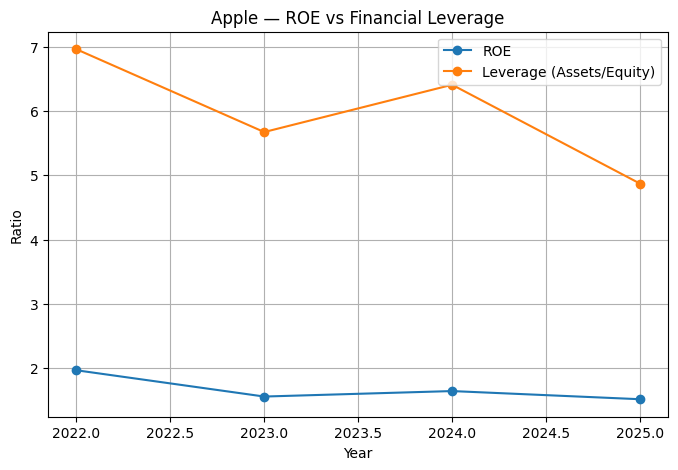

In [9]:
plt.figure(figsize=(8,5))
plt.plot(data.index, data["roe"], marker="o", label="ROE")
plt.plot(data.index, data["leverage"], marker="o", label="Leverage (Assets/Equity)")
plt.title("Apple — ROE vs Financial Leverage")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()


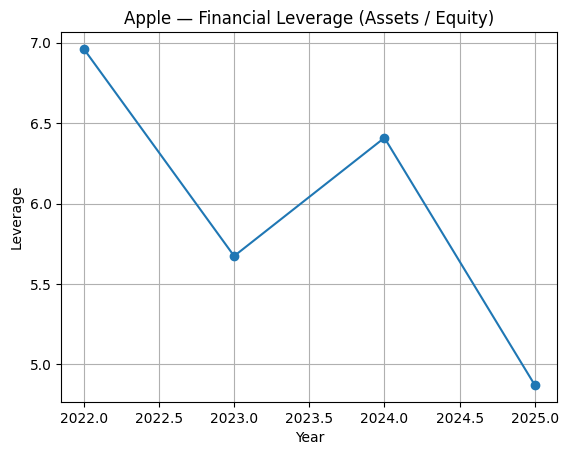

In [10]:
plt.figure()
plt.plot(data.index, data["leverage"], marker="o")
plt.title("Apple — Financial Leverage (Assets / Equity)")
plt.xlabel("Year")
plt.ylabel("Leverage")
plt.grid(True)
plt.show()


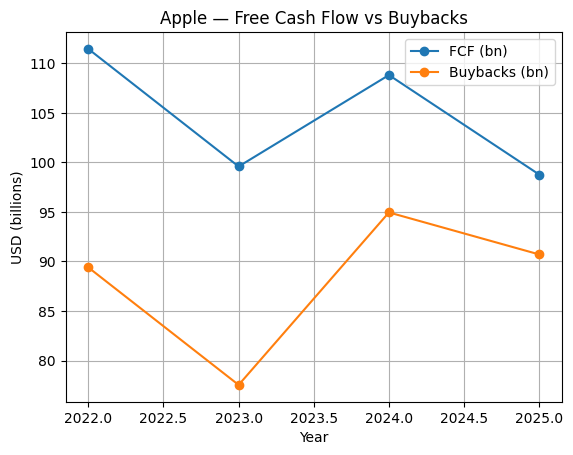

In [11]:
plt.figure()
plt.plot(data.index, data["fcf"]/1e9, marker="o", label="FCF (bn)")
plt.plot(data.index, abs(data["buybacks"])/1e9, marker="o", label="Buybacks (bn)")
plt.title("Apple — Free Cash Flow vs Buybacks")
plt.xlabel("Year")
plt.ylabel("USD (billions)")
plt.legend()
plt.grid(True)
plt.show()


#Présentation des DATA STRUCTURES

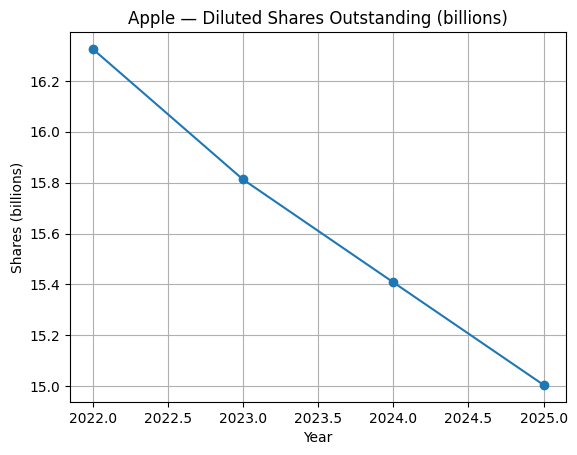

In [12]:
plt.figure()
plt.plot(data.index, data["diluted_shares"]/1e9, marker="o")
plt.title("Apple — Diluted Shares Outstanding (billions)")
plt.xlabel("Year")
plt.ylabel("Shares (billions)")
plt.grid(True)
plt.show()


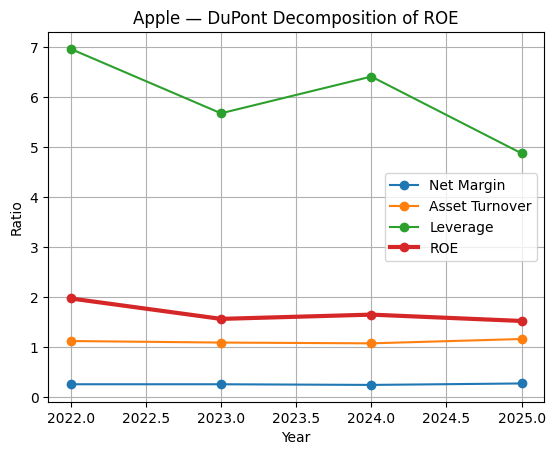

In [13]:
# Calcul Asset Turnover
data["asset_turnover"] = data["revenue"] / data["assets"]

plt.figure()

plt.plot(data.index, data["net_margin"], marker="o", label="Net Margin")
plt.plot(data.index, data["asset_turnover"], marker="o", label="Asset Turnover")
plt.plot(data.index, data["leverage"], marker="o", label="Leverage")
plt.plot(data.index, data["roe"], marker="o", linewidth=3, label="ROE")

plt.title("Apple — DuPont Decomposition of ROE")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()


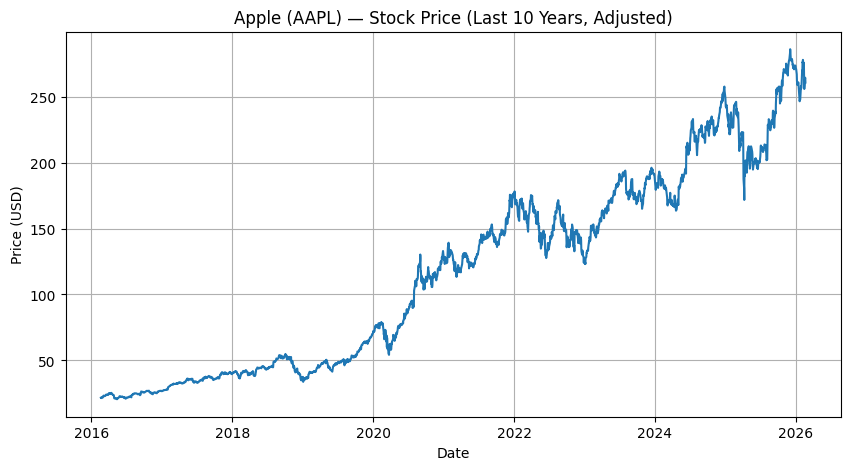

In [ ]:
#GRAPH — Apple stock price (last 10 years)

import yfinance as yf
import matplotlib.pyplot as plt

ticker = "AAPL"

px = yf.download(ticker, period="10y", auto_adjust=True, progress=False)

plt.figure(figsize=(10,5))
plt.plot(px.index, px["Close"])
plt.title("Apple (AAPL) — Stock Price (Last 10 Years, Adjusted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


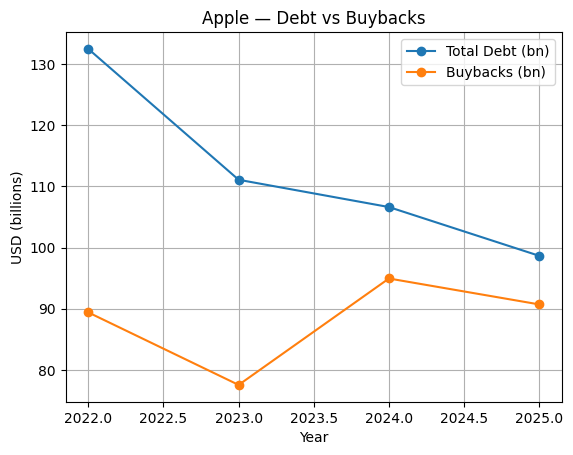

In [15]:
plt.figure()
plt.plot(data.index, data["total_debt"]/1e9, marker="o", label="Total Debt (bn)")
plt.plot(data.index, abs(data["buybacks"])/1e9, marker="o", label="Buybacks (bn)")
plt.title("Apple — Debt vs Buybacks")
plt.xlabel("Year")
plt.ylabel("USD (billions)")
plt.legend()
plt.grid(True)
plt.show()




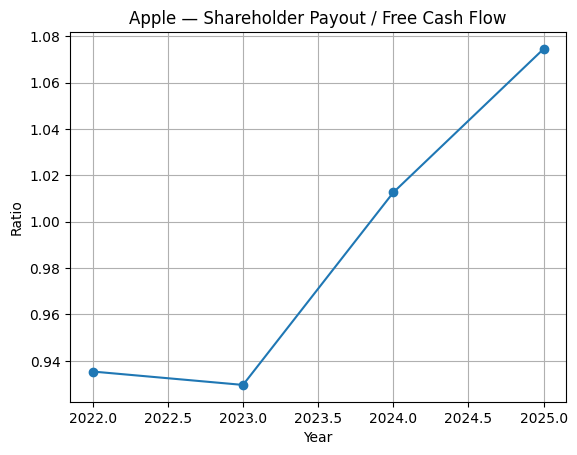

In [16]:
data["shareholder_payout"] = abs(data["buybacks"]) + abs(data["dividends_paid"])
data["payout_ratio_fcf"] = data["shareholder_payout"] / data["fcf"]

plt.figure()
plt.plot(data.index, data["payout_ratio_fcf"], marker="o")
plt.title("Apple — Shareholder Payout / Free Cash Flow")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.grid(True)
plt.show()


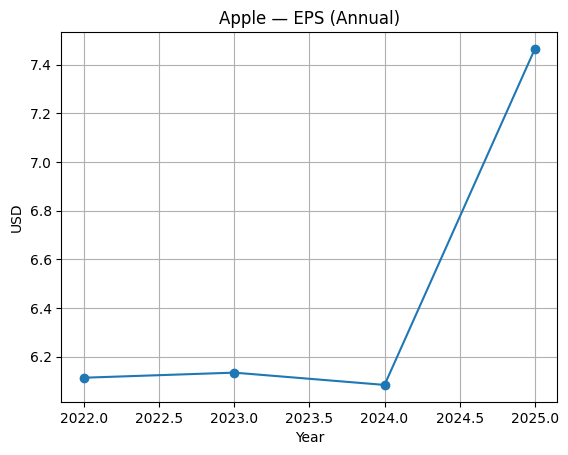

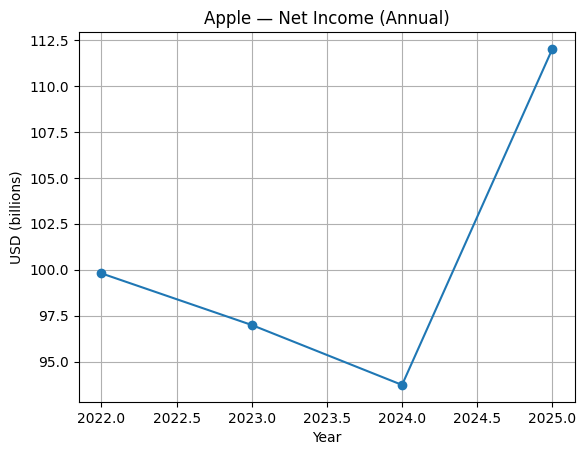

In [17]:
plt.figure()
plt.plot(data.index, data["eps"], marker="o", label="EPS")
plt.title("Apple — EPS (Annual)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(data.index, data["net_income"]/1e9, marker="o", label="Net Income (bn)")
plt.title("Apple — Net Income (Annual)")
plt.xlabel("Year")
plt.ylabel("USD (billions)")
plt.grid(True)
plt.show()
